# Hydrogel-Cell Interaction Test Case

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d

## Input information

In [2]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed_3'
dilated = '_softedge'
shapename = 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3; nu0 = 0.499;

# Spherical Harmonics Analysis Settings
lJmax = 20; lKmax = lJmax; lmax_plot = 60;

# initial guess settings
init_guess_type = 'ur-only' #'ur-only' or 'true'

# regularizations
myalpha = 1     # traction magnitude
mybeta  = 1  # coefficient magnitude

# program switches
plot_figure = True
myord = 1; # myord: p-norm order (1-mean value)

# minimization settings
N_period = 500
maxiter_per_period = 5
CG_gtol = 1e-5

minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'disp': True, 'gtol': CG_gtol}

# dump files for minimization
savename = shapename+('_b%.0e'%(mybeta))+('_lmax%d'%lJmax)+smoothed+dilated

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join('..', 'shelastic', 'default_modes')

#################################################################################
mu = 1.; nu = nu0;
Dmat = generate_submat(loadmat(os.path.join(coeff_dir, 'Umodes.mat')),
                       mu, nu, lKmax, lJmax, shtype=shtype, verbose=True).tocsc()
Cmat = generate_submat(loadmat(os.path.join(coeff_dir, 'Tmodes.mat')),
                       mu, nu, lKmax, lJmax, shtype=shtype, verbose=True).tocsc()

Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


## Load the geometry

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)


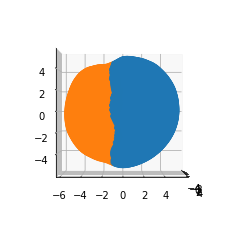

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if dilated == '_softedge':
    masktype = np.float
else:
    masktype = np.int
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(masktype)
else:
    mask = np.genfromtxt(maskfile, dtype=masktype)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

if dilated == '_softedge':
    Tfv = (mask > 0.5)
else:
    Tfv = mask.astype(np.bool)

#### Plot the geometry (Vp) ####
if plot_figure:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')

    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

    ax.view_init(azim=0, elev=0)
    plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [4]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.1011, r0 = 5.2528


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

Conversion between complex and real spherical harmonics, for $m>0$

$$
f_{lm} = \left[f_l^m+(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_{l-m}=i\left[f_l^m-(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_l^m = (f_{lm}-if_{l-m})/\sqrt{2}\\
f_l^{-m} = (-1)^m(f_{lm}+if_{l-m})/\sqrt{2}
$$

for $m=0$:

$$
f_{l0} = f_l^0
$$


## 1. Obtain the initial guess

First thing to try is assuming that the deformation only happens on $r$-direction.

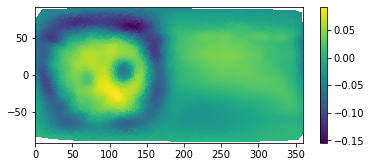

In [5]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[...,0], Vp[...,1], Vp[...,2])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

ur = (Vr - r0)/r0

# plot 2d map of the radial displacement
if plot_figure:
    pVlon = Vlon - 180
    pVlon[pVlon < 0] += 360
    fig,ax = plt.subplots(1,1,figsize=(6,2.5))
    im = ax.tripcolor(pVlon, Vlat, ur)
    fig.colorbar(im)
    ax.axis('equal')
    ax.set_xlim(0, 360)
    ax.set_ylim(-90, 90)
    plt.show()

## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion.

### Develop the interpolation function for $u_r(\theta,\varphi)$ from data

0.0016845141038542705
kind = 'real'
grid = 'GLQ'
nlat = 31
nlon = 61
lmax = 30
(33, 62) (33, 62) (33, 62)
(33,) (62,)
(2046,)
(8136,) 0.0011026859283447266
[-1.17990165e-03 -1.77563679e-03 -1.16784381e-03 ...  2.39349301e-04
 -6.92636508e-04  8.65200470e-06]


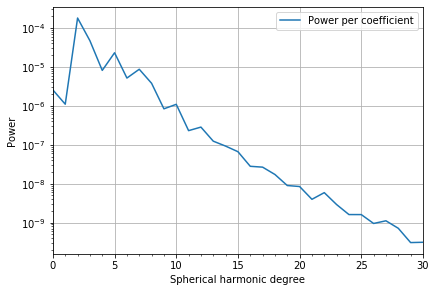

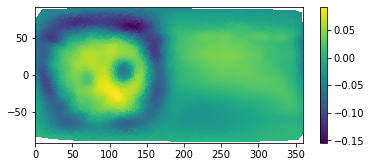

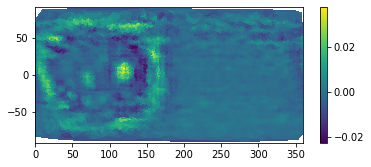

In [6]:
urcilm_interp, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax+10)
print(chi2)

ucoeff_interp = pyshtools.SHCoeffs.from_array(urcilm_interp)
urgrid_interp = ucoeff_interp.expand('GLQ')

if plot_figure:
    fig, ax = ucoeff_interp.plot_spectrum(unit='per_lm', show=False)
    urgrid_interp.info()

from scipy.interpolate import RectBivariateSpline

lats = urgrid_interp.lats(); lons = urgrid_interp.lons();
lats_circular = np.hstack(([90.], lats, [-90.]))
lons_circular = np.append(lons, 360)
LONS, LATS = np.meshgrid(lons_circular, lats_circular)
xmesh = urgrid_interp.to_array().copy()
fpoints = np.zeros_like(LONS)
fpoints[1:-1, :-1] = xmesh
fpoints[0, :] = np.mean(xmesh[0,:], axis=0)  # not exact !
fpoints[-1, :] = np.mean(xmesh[-1,:], axis=0)  # not exact !
fpoints[1:-1, -1] = xmesh[:, 0]
print(LATS.shape, LONS.shape, fpoints.shape)
print(lats_circular.shape, lons_circular.shape)
f_interp = RectBivariateSpline(lats_circular[::-1], lons_circular, fpoints[::-1, ], kx=1, ky=1)

## Test the interpolation algorithm

tic = time.time()
ur_interp = f_interp.ev(Vlat, Vlon)
toc = time.time()
print(f_interp.get_coeffs().shape)
print(ur_interp.shape, toc-tic)
print(ur_interp - ur)

if plot_figure:
    fig, axs = plt.subplots(1,1,figsize=(6,2.5))
    im = axs.tripcolor(pVlon, Vlat, ur)
    fig.colorbar(im)
    axs.axis('equal')
    axs.set_xlim(0, 360)
    axs.set_ylim(-90, 90)
    fig, axs = plt.subplots(1,1,figsize=(6,2.5))
    im = axs.tripcolor(pVlon, Vlat, (ur_interp-ur)*r0)
    fig.colorbar(im)
    axs.axis('equal')
    axs.set_xlim(0, 360)
    axs.set_ylim(-90, 90)
    plt.show()

### 2.3 Target function including shape and traction

We use the surface shift function to define the degree of freedom:

In [7]:
def GLQCartCoord(lmax):
    latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax)
    lon = np.deg2rad(lonsdeg)
    colat = np.deg2rad(90-latsdeg)
    PHI, THETA = np.meshgrid(lon, colat)
    R = np.ones_like(PHI)
    X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
    return np.stack([X, Y, Z], axis=-1)

latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon0, lat0 = np.meshgrid(lonsdeg, latsdeg)
X0shear = np.stack([lat0, lon0], axis=-1)
X0 = r0 * GLQCartCoord(lJmax)

def usurf2vec(u_surf, X0surf=X0shear, X0=X0/r0, f_interp=f_interp):
    x_surf = X0surf + u_surf.reshape(X0surf.shape)
    lat_x = x_surf[..., 0]; lon_x = x_surf[..., 1];
    Theta_x = np.deg2rad(90 - lat_x); Phi_x = np.deg2rad(lon_x);
    R_x = f_interp.ev(lat_x, lon_x)+1
    x = np.stack(SphCoord_to_CartCoord(R_x, Theta_x, Phi_x), axis=-1)
    umesh = x - X0
    Uvec  = SHmesh2Vec(umesh, lmax=lJmax)
    aK    = spsolve(Dmat, Uvec.T)
    Tvec  = Cmat.dot(aK)
    return Uvec, aK, Tvec

### Define the initial guess

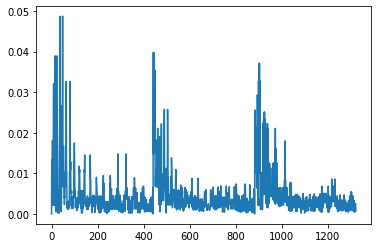

Displacement in Spherical Coordinates...


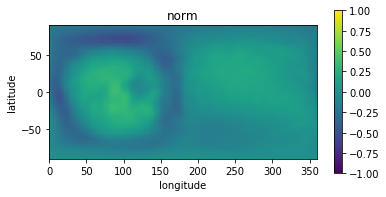

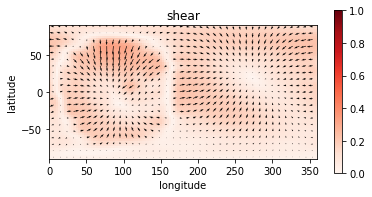

Traction in Spherical Coordinates...


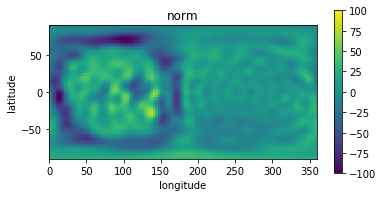

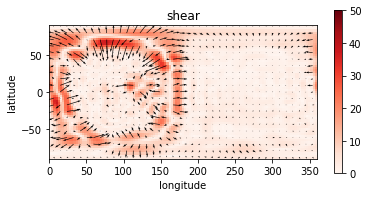

In [8]:
import glob
filelist = glob.glob('AK_'+savename+'_??.npz')
nfile = len(filelist)
if nfile > 0:
    u0_surf = np.load('AK_'+savename+'_%02d.npz'%(nfile-1))['u_surf_list'][-1, ...]
elif init_guess_type == 'ur-only':
    u0_surf = np.zeros_like(X0shear)

U0vec, aK, T0vec = usurf2vec(u0_surf)
if plot_figure:
    fig, ax = plt.subplots()
    ax.plot(np.abs(T0vec))
    plt.show()
    print('Displacement in Spherical Coordinates...')
    fig, ax = visSHVec(U0vec*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True,
                       n_vrange=(-1, 1), s_vrange=(0, 1),
                       config_quiver=(2, 3, 'k', 10), lonshift=180, figsize=(6,3))
    print('Traction in Spherical Coordinates...')
    fig, ax = visSHVec((T0vec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                       n_vrange=(-100, 100), s_vrange=(0, 50),
                       config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))

### Define the traction free region based on the initial guess

In [9]:
# Define weights and traction free region
Xt = GLQCartCoord(lJmax) + SHVec2mesh(U0vec*r0, lmax=lJmax, SphCoord=False, Complex=True)
dist2mat = np.linalg.norm((Xt[..., np.newaxis, :] - Vp)/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
if dilated == '_softedge':
    isTfv = mask[arg_list_x]
else:
    isTfv = Tfv[arg_list_x]

print(isTfv.dtype, isTfv.shape)

float64 (21, 41)


In [10]:
def usurf2Eel(u_surf, X0surf=X0shear, X0=X0/r0, f_interp=f_interp):
    Uvec, aK, Tvec = usurf2vec(u_surf, X0surf=X0surf, X0=X0, f_interp=f_interp)
    return np.vdot(Uvec, Tvec).real*2*np.pi

def usurf2Tres(u_surf, X0surf=X0shear, X0=X0/r0, f_interp=f_interp, isTfv=isTfv, lmax=lJmax, 
               lat_weights=None, vert_weight=1, norm_order=1):
    if lat_weights is None:
        lat_weights = np.ones((lmax+1, 2*lmax+1))
    Uvec, aK, Tvec = usurf2vec(u_surf, X0surf=X0surf, X0=X0, f_interp=f_interp)
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    tmesh = np.empty((lmax+1, 2*lmax+1, 3))
    for k in range(3):
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    if isTfv.dtype == np.bool:
        tvalues = np.sum((tmesh[isTfv, :]*vert_weight)**2, axis=-1)
        lat_weights_value = lat_weights[isTfv]**2
    else:
        tvalues = np.sum((tmesh * vert_weight)**2, axis=-1)*isTfv
        lat_weights_value = lat_weights**2
    if norm_order > 1:
        Tdist = np.linalg.norm(tvalues*lat_weights_value, ord=norm_order)
    else:
        Tdist = np.mean(tvalues*lat_weights_value)
    return Tdist

def usurf2dr(u_surf, beta=1, norm_order=1, X0surf=X0shear, X0=X0/r0, f_interp=f_interp, isTfv=isTfv, lmax=lJmax, 
             lat_weights=None, vert_weight=1):
    if lat_weights is None:
        lat_weights = np.ones((lmax+1, 2*lmax+1))
    Uvec, aK, Tvec = usurf2vec(u_surf, X0surf=X0surf, X0=X0, f_interp=f_interp)
    tcvec = Tvec.reshape(3, -1)
    # expand the displacement and traction field onto a mesh
    tmesh = np.empty((lmax+1, 2*lmax+1, 3))
    for k in range(3):
        tcilm = SHVectorToCilm(tcvec[k, :])
        tgrid = pyshtools.SHCoeffs.from_array(tcilm).expand('GLQ')
        tmesh[..., k] = tgrid.to_array().real
    if isTfv.dtype == np.bool:
        tvalues = np.sum((tmesh[isTfv, :]*vert_weight)**2, axis=-1)
        lat_weights_value = lat_weights[isTfv]**2
    else:
        tvalues = np.sum((tmesh * vert_weight)**2, axis=-1)*isTfv
        lat_weights_value = lat_weights**2
    if norm_order > 1:
        Tdist = np.linalg.norm(tvalues*lat_weights_value, ord=norm_order)
    else:
        Tdist = np.mean(tvalues*lat_weights_value)
    Eel = np.vdot(Uvec, Tvec).real*2*np.pi
    return Tdist + beta*Eel

In [11]:
print('Traction residual: %.4e Pa'%(usurf2Tres(u0_surf, norm_order=np.inf)*mu0))
print('Elastic energy: %.4e pJ'%(usurf2Eel(u0_surf)*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e'%(usurf2Tres(u0_surf, norm_order=np.inf), usurf2Eel(u0_surf)))

Traction residual: 1.2899e+02 Pa
Elastic energy: 7.2775e-04 pJ
funval: 1.2899e+00 5.0213e-02


In [ ]:
from scipy.optimize import minimize, Bounds, brute

def print_iter(xk):
    print('%13.4e%13.4e'%(usurf2Tres(xk, norm_order=myord)*mu0, usurf2Eel(xk)*(r0/1e6)**3*mu0*1e12))

bd = Bounds(-6, 6)
u_surf_list = []
u_surf = u0_surf.copy()
for i in range(N_period):
    print('Period %d'%i)
    u_res = minimize(usurf2dr, u_surf.flatten(), args=(mybeta, myord), method = minimizer,
                     options=minimizer_config, callback=print_iter)
    if u_res.success:
        break
    u_surf = u_res.x.copy()
    u_surf_list.append(u_surf)

Period 0
   7.2166e-01   7.2765e-04
   7.1885e-01   7.2772e-04
   7.1917e-01   7.2764e-04
   7.1832e-01   7.2766e-04
   7.1781e-01   7.2772e-04
         Current function value: 0.057388
         Iterations: 5
         Function evaluations: 46548
         Gradient evaluations: 27
Period 1
   7.1822e-01   7.2763e-04
   7.1769e-01   7.2756e-04
   7.1748e-01   7.2757e-04
   7.1798e-01   7.2745e-04
   7.1754e-01   7.2747e-04
         Current function value: 0.057368
         Iterations: 5
         Function evaluations: 44824
         Gradient evaluations: 26
Period 2
   7.1712e-01   7.2752e-04
   7.1707e-01   7.2747e-04
   7.1670e-01   7.2750e-04
   7.1763e-01   7.2722e-04
   7.1598e-01   7.2706e-04
         Current function value: 0.057325
         Iterations: 5
         Function evaluations: 46548
         Gradient evaluations: 27
Period 3
   7.1449e-01   7.2719e-04
   7.1391e-01   7.2696e-04
   7.1304e-01   7.2683e-04
   7.1358e-01   7.2671e-04
   7.1367e-01   7.2667e-04
         Current

   7.0221e-01   7.2209e-04
   7.0285e-01   7.2192e-04
         Current function value: 0.056838
         Iterations: 5
         Function evaluations: 48272
         Gradient evaluations: 28
Period 25
   7.0204e-01   7.2200e-04
   7.0212e-01   7.2192e-04
   7.0185e-01   7.2193e-04
   7.0214e-01   7.2187e-04
   7.0229e-01   7.2181e-04
         Current function value: 0.056825
         Iterations: 5
         Function evaluations: 44824
         Gradient evaluations: 26
Period 26
   7.0188e-01   7.2186e-04
   7.0186e-01   7.2181e-04
   7.0227e-01   7.2172e-04
   7.0170e-01   7.2174e-04
   7.0158e-01   7.2171e-04
         Current function value: 0.056812
         Iterations: 5
         Function evaluations: 48272
         Gradient evaluations: 28
Period 27
   7.0181e-01   7.2166e-04
   7.0139e-01   7.2171e-04
   7.0145e-01   7.2167e-04
   7.0160e-01   7.2164e-04
   7.0148e-01   7.2164e-04
         Current function value: 0.056805
         Iterations: 5
         Function evaluations: 43100
 

   6.9682e-01   7.1895e-04
   6.9687e-01   7.1893e-04
   6.9638e-01   7.1892e-04
   6.9697e-01   7.1880e-04
   6.9827e-01   7.1854e-04
         Current function value: 0.056559
         Iterations: 5
         Function evaluations: 46548
         Gradient evaluations: 27
Period 50
   6.9615e-01   7.1871e-04
   6.9618e-01   7.1858e-04
   6.9582e-01   7.1862e-04
   6.9551e-01   7.1858e-04
   6.9590e-01   7.1849e-04
         Current function value: 0.056532
         Iterations: 5
         Function evaluations: 46548
         Gradient evaluations: 27
Period 51
   6.9565e-01   7.1847e-04
   6.9586e-01   7.1842e-04
   6.9567e-01   7.1839e-04
   6.9602e-01   7.1833e-04
   6.9657e-01   7.1821e-04
         Current function value: 0.056520
         Iterations: 5
         Function evaluations: 49996
         Gradient evaluations: 29
Period 52
   6.9570e-01   7.1830e-04
   6.9575e-01   7.1819e-04
   6.9540e-01   7.1823e-04
   6.9533e-01   7.1823e-04
   6.9564e-01   7.1817e-04
         Current funct

   6.9276e-01   7.1586e-04
   6.9216e-01   7.1591e-04
         Current function value: 0.056317
         Iterations: 5
         Function evaluations: 48272
         Gradient evaluations: 28
Period 74
   6.9251e-01   7.1585e-04
   6.9266e-01   7.1576e-04
   6.9233e-01   7.1580e-04
   6.9243e-01   7.1577e-04
   6.9213e-01   7.1579e-04
         Current function value: 0.056309
         Iterations: 5
         Function evaluations: 43100
         Gradient evaluations: 25
Period 75
   6.9239e-01   7.1575e-04
   6.9253e-01   7.1570e-04
   6.9220e-01   7.1573e-04
   6.9255e-01   7.1565e-04
   6.9185e-01   7.1572e-04
         Current function value: 0.056301
         Iterations: 5
         Function evaluations: 44824
         Gradient evaluations: 26
Period 76
   6.9231e-01   7.1562e-04
   6.9234e-01   7.1556e-04
   6.9200e-01   7.1560e-04
   6.9216e-01   7.1549e-04
   6.9168e-01   7.1554e-04
         Current function value: 0.056287
         Iterations: 5
         Function evaluations: 44824
 

In [13]:
print('Traction residual: %.4e Pa'%(usurf2Tres(u_surf)*mu0))
print('Elastic energy: %.4e pJ'%(usurf2Eel(u_surf)*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e'%(usurf2Tres(u_surf), usurf2Eel(u_surf)))

Traction residual: 6.8669e-01 Pa
Elastic energy: 7.2775e-04 pJ
funval: 6.8669e-03 5.0213e-02


     fun: 0.0570794913380928
     jac: array([ 7.31088221e-07,  1.40164047e-07,  3.72063369e-07, ...,
        3.21306288e-08,  6.60307705e-07, -2.84053385e-08])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 43100
     nit: 5
    njev: 25
  status: 1
 success: False
       x: array([-0.31511719,  1.00841131,  2.27258017, ...,  0.76833625,
       -2.38941653,  0.94677828])


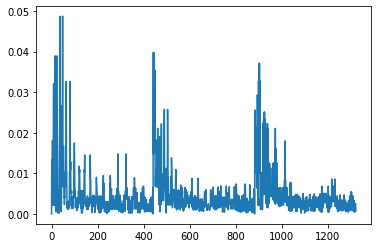

Displacement in Spherical Coordinates...


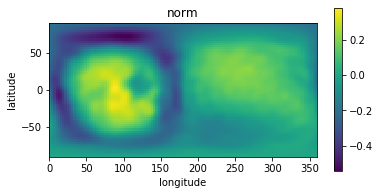

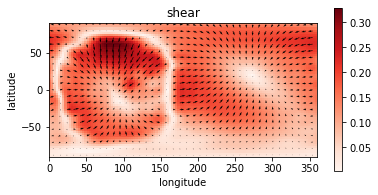

Traction in Spherical Coordinates...


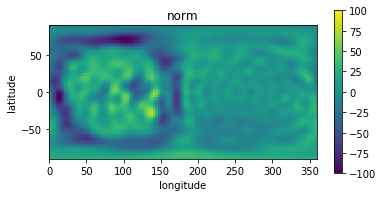

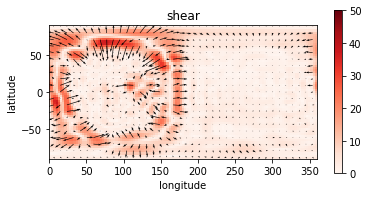

In [14]:
print(u_res)
u_surf = u_res.x

Usurfvec, aK, Tsurfvec = usurf2vec(u_surf)

if plot_figure:
    fig, ax = plt.subplots()
    # ax.plot(np.abs(T_usr_vec))
    ax.plot(np.abs(Tsurfvec))
    plt.show()

    print('Displacement in Spherical Coordinates...')
    fig, ax = visSHVec(Usurfvec*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, #s_vrange=(0,0.01),
                       config_quiver=(2, 3, 'k', 10), lonshift=180, figsize=(6,3))
    print('Traction in Spherical Coordinates...')
    fig, ax = visSHVec((Tsurfvec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                       n_vrange=(-100, 100), s_vrange=(0, 50),
                       config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))

In [15]:
import glob
filelist = glob.glob('AK_'+savename+'_??.npz')
nfile = len(filelist)
np.savez('AK_'+savename+'_%02d.npz'%(nfile), 
         AK_iter=aK, u_surf_list=np.stack(u_surf_list, axis=0), 
         beta=mybeta, N=N_period)